# Scene Segmentation with Neural Networks

Neuro Data Design I: Fall 2021

This tutorial provides a walkthrough for applying a neural network (Unet architecture) for scene segmentation. Following this, an attempt was made to apply this same architecture to the Proglearn framework.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from functions.scene_segmentation_nn_tutorial_functions import *  # cv2 required
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input

## Preprocessing

Images from the ADE20K consistency set are used in this exercise, which contains 64 images where different objects in the scene are segmented into different colors. However, between different images, the same objects do not necessarily share the same color. As a result, the preprocessing step not only involves separating the data into train and test sets but also relabeling pixel values from color values to class values.

In [3]:
# data directory
datadir = "ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/"
imgkeys = [im.split("_seg")[0] for im in os.listdir(datadir) if "_seg" in im]
lblpaths = [datadir + im for im in os.listdir(datadir) if "_seg" in im]
imgpaths = [
    datadir + im
    for im in os.listdir(datadir)
    if ".jpg" in im and im.split(".jpg")[0] in imgkeys
]


imgpaths.sort()
lblpaths.sort()
print("Total # of images =", len(imgpaths))
print("Total # of labels =", len(lblpaths))

Total # of images = 64
Total # of labels = 64


The images are loaded and preprocessed

In [4]:
# load images
X, Y, n_classes = load_data(imgpaths, lblpaths)

1460 classes found


Hyper parameters for training:

- `n_epoch`: number of training epochs
- `n_batch_items`: number of training points per epoch
- `n_test`: number of testing points
- `n_val`: number of validation points
- `learn_rate`: learning rate

In [5]:
# hyperparameters
n_epoch = 200
n_batch_items = 3
n_test = 10
n_val = 10
learn_rate = 0.001

Create neural network (Unet)

In [6]:
# create Unet model
input_layer = Input(shape=X[0].shape)
model = unet(input_layer, n_classes)

In [7]:
# train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=n_test)

## Neural Network

A Unet neural network is constructed, which is a type of neural network used in image segmentation commonly used in biomedical applications. This network uses the Adam optimizer and computes loss via Sparse Categorical Crossentropy. An aditional metric called the Dice score iis also computed, which calculates the similarity between the predicted segmentation and the ground truth segmentation.

In [8]:
# compile model with Adam optimizer, Spare Categorical Cross entropy loss, and include dice coefficient calculation
model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy", dice],
)

### Training

The Unet model is trained according to the hyperparameters previously specified.

In [ ]:
# compile model with Adam optimizer, Spare Categorical Cross entropy loss, and include dice coefficient calculation
model_history = model.fit(
    x=X_train,
    y=Y_train,
    validation_split=n_val / len(X_train),
    epochs=n_epoch,
    batch_size=n_batch_items,
    verbose=2,
)

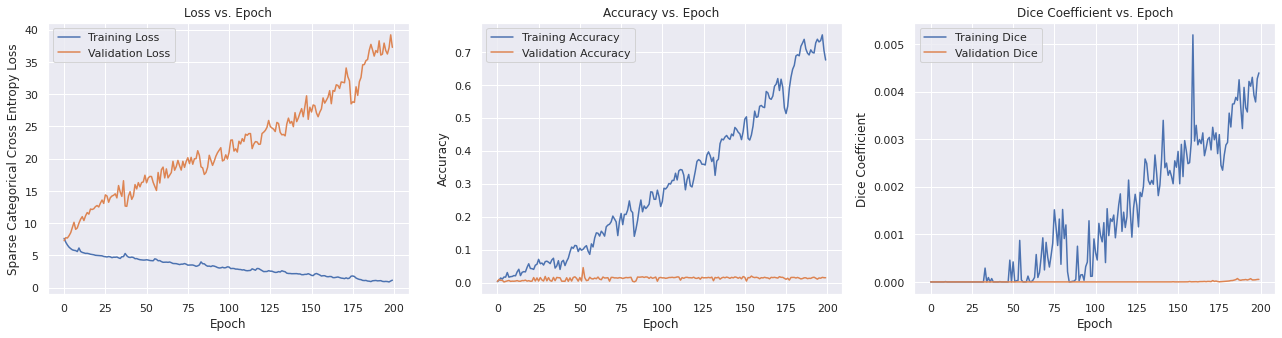

In [23]:
plot_metrics(model_history)

### Testing

With the model now trained, predictions are made with the model to evaluate its accuracy.

Evaluation on held-out testing data:

Mean Test Dice: 0.0002
Mean Test Accuracy: 0.0107


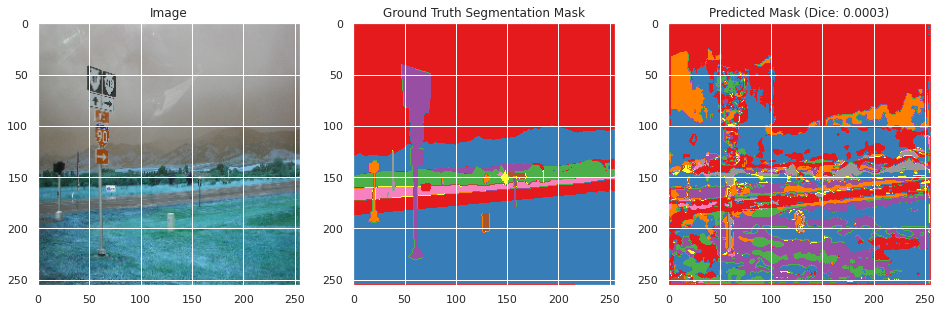

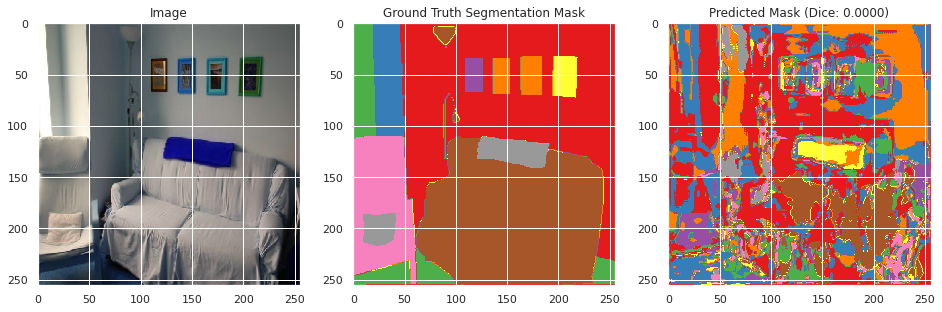

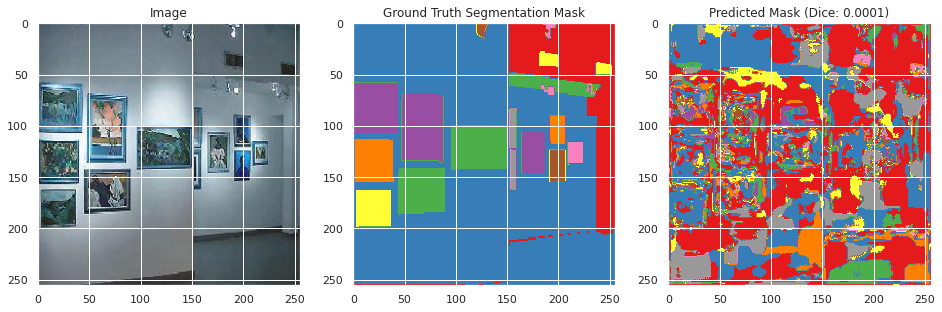

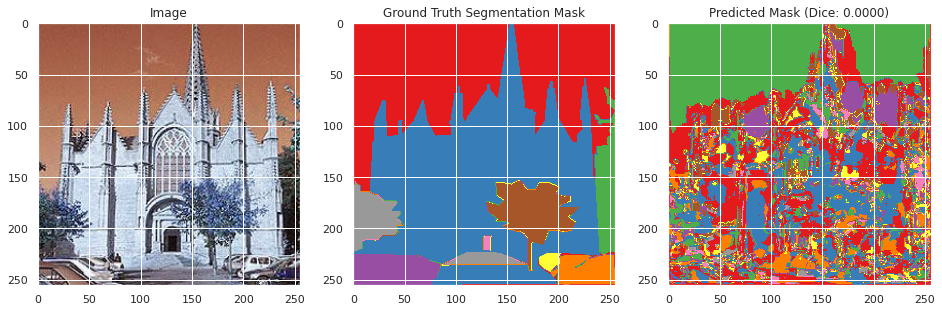

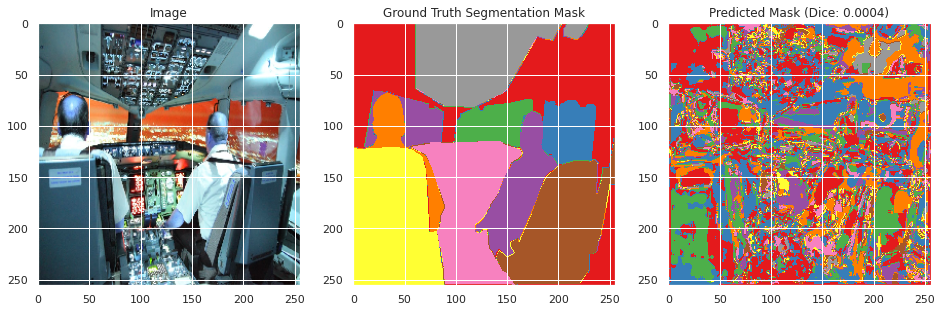

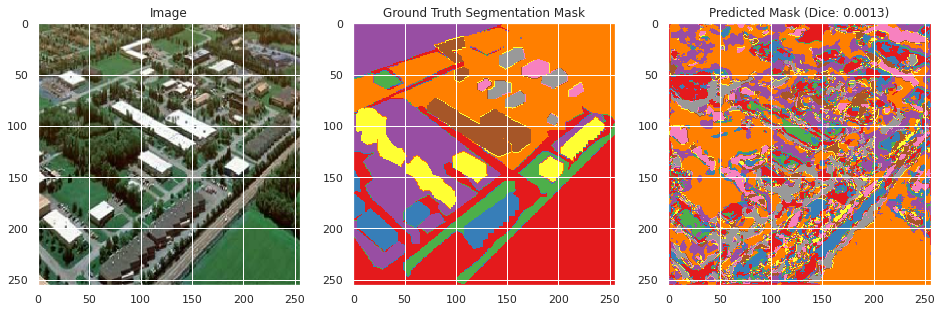

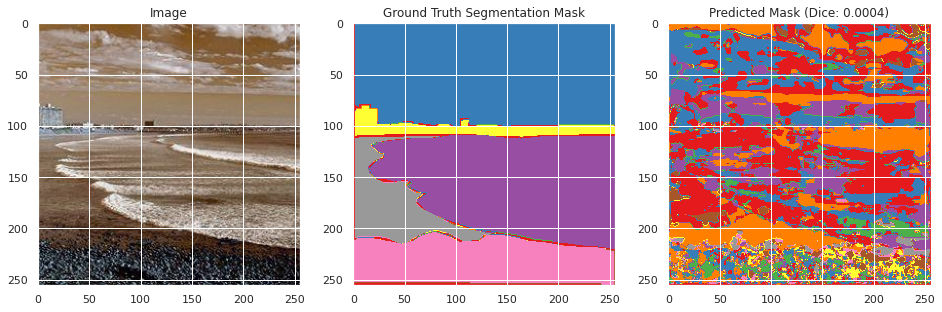

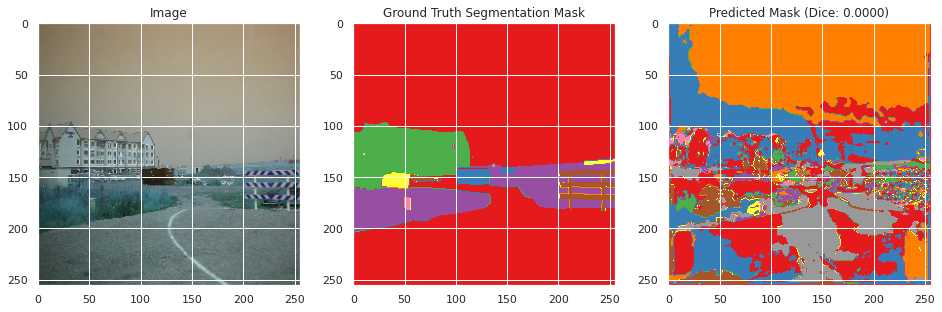

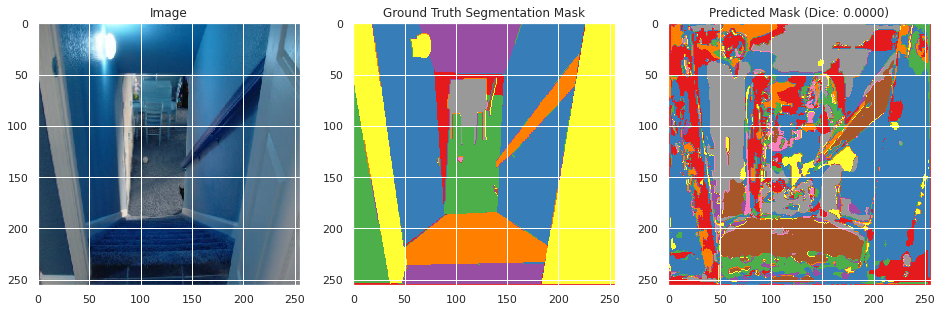

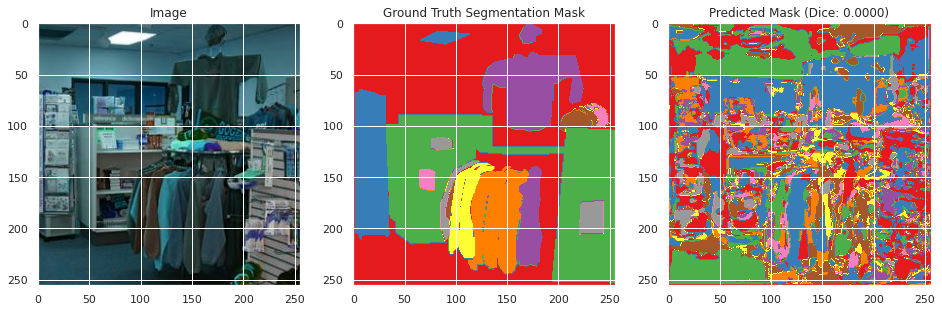

In [24]:
evaluate(model, X_test, Y_test)

Evaluation on training and validation data:

In [ ]:
evaluate(model, X_train, Y_train)

From inspecting the data qualitatively, the neural network appears to perform moderately well segmenting the training images image similarly to the ground truth segmentation, but does not perform well in the classification with a mean Dice score of 0.0036 and an accuracy of 0.6008. However, this may be the result of the large number of classes with overlapping meanings. However, the images do not perform as well on the testing data with a Dice score of 0.002 and an accuracy of 0.0107, and qualitative inspection indicates significantly less well defined segmentation as the ground truth segmentation mask. This suggests that the neural network overfitted to the training data, which appears to be confirmed by the rising validation loss during training. This is likely due to the small size of the dataset and lack of overlapping colors between the ground truth segmentation masks between images.